Same comparisons except this is more recent(Sep 24) restart file for the simulation.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import netCDF4 as nc
import numpy as np
import datetime as dt
import pytz, datetime
import scipy.io
import arrow
import os
from salishsea_tools import nc_tools, viz_tools, tidetools, stormtools, bathy_tools
from matplotlib import reload
from __future__ import division
import drifter

In [2]:
grid = nc.Dataset('/ocean/jieliu/research/meopar/river-treatment/bathy_meter_SalishSea6.nc','r')
bathy, X, Y = tidetools.get_bathy_data(grid)
lats = grid.variables['nav_lat']
lons = grid.variables['nav_lon']
bath = grid.variables['Bathymetry']

In [3]:
tracersT = nc.Dataset('/data/jieliu/MEOPAR/river-treatment/oct8_10RFdailySmoo/\
SalishSea_1h_20141008_20141010_grid_T.nc')
ssh = tracersT.variables['sossheig']
timesteps = tracersT.variables['time_counter']
nc_tools.timestamp(tracersT, 0)

<Arrow [2014-10-08T00:30:00+00:00]>

#  Bathymetry with the jetty

In [4]:
bathy_10 = nc.Dataset('/ocean/jieliu/research/meopar/river-treatment/bathy_meter_SalishSea10.nc','r' )
bathyy_10 = bathy_10.variables['Bathymetry']
lon_10 = bathy_10.variables['nav_lon']
lat_10 = bathy_10.variables['nav_lat']

/home/jieliu/anaconda3/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


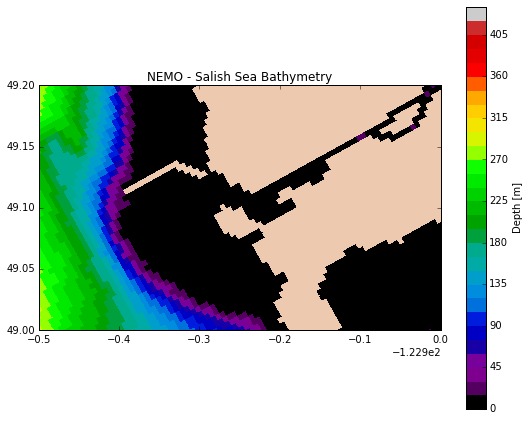

In [5]:
fig = bathy_tools.plot_colourmesh(
    bathy_10, 'NEMO - Salish Sea Bathymetry', 
    axis_limits=(-123.4, -122.9, 49., 49.2), colour_map='spectral', bins=30)


In [6]:
def plotoct_mewold(lon,lat,part,start,end,start_d,end_d,day,hour,minute,duration):
    fig, axs = plt.subplots(2, 2, figsize=(11, 10))
    viz_tools.plot_coastline(axs[0,0],grid,coords='map')
    viz_tools.plot_coastline(axs[0,0],grid,coords='map',isobath=4,color='FireBrick')
    viz_tools.plot_coastline(axs[0,0],grid,coords='map',isobath=20,color='OrangeRed')
    axs[0,0].set_xlim([-123.6,-123])
    axs[0,0].set_ylim([48.8,49.4])
    axs[0,0].set_xticks([-123.6, -123.4, -123.2,-123])
    axs[0,0].set_xticklabels([-123.6, -123.4, -123.2,-123])
    axs[0,0].set_xlabel('Longitude')
    axs[0,0].set_ylabel('Latitude')
    
    colors=['g','DodgerBlue','tomato','Olive','DarkViolet']
    for i, key in enumerate(lon.keys()):
        axs[0,0].scatter(lon[key][1:,part],lat[key][1:,part],marker='o',color=colors[i],label=key)
        axs[0,0].scatter(lon[key][0,part],lat[key][0,part],color='0.30',marker='s')
    axs[0,0].plot(-123-np.array([18.2,13.7,12])/60.,49+np.array([6.4,8,7.6])/60.,'-k',lw=2,color='Indigo')
    axs[0,0].legend(loc='upper center', bbox_to_anchor=(0.5, 1.2),
          ncol=5, fancybox=False, shadow=True)
    
    axs[0,1].plot(timesteps[0:48],ssh[0:48,466,329],'-k')
    
    axs[0,1].set_xticklabels([])
    axs[0,1].set_ylabel('Water level (m)')
    axs[0,1].set_xlabel('Oct 8 - Oct 9 (hrs)')
    axs[0,1].set_title('sossheig, ~Point Atkinson')
        
    t=hour
    axs[0,1].plot([timesteps[t],timesteps[t]],[-2.0,1.5],'r-',label='start')
    
    t2=hour+duration
    axs[0,1].plot([timesteps[t2],timesteps[t2]],[-2.0,1.5],'b-',label='end')
    
    [wind_speed,wind_dir,temp,time, lat, lon] = stormtools.get_EC_observations('Sandheads',start,end)   
    axs[1,0].plot(time,wind_speed,'-k')
    axs[1,0].set_xlim(dt.datetime(2014,10,start_d),dt.datetime(2014,10,end_d))
    axs[1,0].set_xticklabels([])
    axs[1,0].set_xlabel('Oct 8 - Oct 9 (hrs)')
    axs[1,0].set_ylabel('Wind Speed (m/s)')
    axs[1,0].set_title('Sandheads')
    
    diff = 24 - hour
    hour2 = duration - diff
    day2 = day +1
    
    t=dt.datetime(2014,10,day,hour,minute)
    axs[1,0].plot([t,t],[0,10],'r-',label='start')
    tt=dt.datetime(2014,10,day2,hour2,minute)
    axs[1,0].plot([tt,tt],[0,10],'b-',label='end')
    axs[1,0].legend(loc='upper left')

    axs[1,1].plot(time,wind_dir,'-k')
    axs[1,1].set_xlim(dt.datetime(2014,10,start_d),dt.datetime(2014,10,end_d))
    axs[1,1].set_xticklabels([])
    axs[1,1].set_xlabel('Oct 8 - Oct 9 (hrs)')
    axs[1,1].set_ylabel('Wind Direction (deg CCW of E)')
    axs[1,1].set_title('Sandheads')
    
    t=dt.datetime(2014,10,day,hour,minute)
    axs[1,1].plot([t,t],[0,350],'r-',label='start')
    tt=dt.datetime(2014,10,day2,hour2,minute)
    axs[1,1].plot([tt,tt],[0,350],'b-',label='end')
    axs[1,1].legend(loc='upper left')
    return fig

In [7]:
def dist_buoy_particle(lon_dri, lat_dri, lon_par,lat_par,part):
    dist = {};
    for run in runs:
        dist[run] = np.sqrt((lon_par[run][1][part] - lon_dri)**2 +\
        (lat_par[run][1][part] - lat_dri)**2) *111*np.cos(lat_par[run][1][part]*np.pi/180)
    return dist

In [8]:
directories = ['oct8_10jetty1e0605','oct8_10RFdailySmoo', 'oct8_10reduceviscosity','oct8_101e061e05','4-10oct14']
bases = ['/data/jieliu/MEOPAR/river-treatment/','/data/dlatorne/MEOPAR/SalishSea/nowcast/early-days/']
sfile_pattern = ['{}/SalishSea_1h_20141008_20141010_grid_T.nc','{}/SalishSea_1h_20141004_20141010_grid_T.nc']
ufile_pattern = ['{}/SalishSea_1h_20141008_20141010_grid_U.nc','{}/SalishSea_1h_20141004_20141010_grid_U.nc']
vfile_pattern = ['{}/SalishSea_1h_20141008_20141010_grid_V.nc', '{}/SalishSea_1h_20141004_20141010_grid_V.nc']
Ss={};Us={};Vs={};depths={};
##load non-nowcasts results
for directory in directories: 
    if directory == directories[-1]:
        path = os.path.join(bases[1],sfile_pattern[1].format(directory))
        f = nc.Dataset(path,'r');
        Ss[directory] = f.variables['vosaline']
        depths[directory] = f.variables['deptht'] 
        path = os.path.join(bases[1],ufile_pattern[1].format(directory))
        f = nc.Dataset(path,'r');
        Us[directory] = f.variables['vozocrtx']
        path = os.path.join(bases[1],vfile_pattern[1].format(directory))
        f = nc.Dataset(path,'r');
        Vs[directory] = f.variables['vomecrty']
    else:
        print('non-nowcast')
        path = os.path.join(bases[0],sfile_pattern[0].format(directory))
        f = nc.Dataset(path,'r');
        Ss[directory] = f.variables['vosaline']
        depths[directory] = f.variables['deptht']
        path = os.path.join(bases[0],ufile_pattern[0].format(directory))
        f = nc.Dataset(path,'r');
        Us[directory] = f.variables['vozocrtx']
        path = os.path.join(bases[0],vfile_pattern[0].format(directory))
        f = nc.Dataset(path,'r');
        Vs[directory] = f.variables['vomecrty']   

non-nowcast
non-nowcast
non-nowcast
non-nowcast


In [9]:
def plot_salinity_uv(j,i,t, zmin,zmax):
    """This function was made to plot salinity, u, v profiles at the
       released position.    """
    fig, axs =plt.subplots(1,3, figsize = (15,6))
    colors=['g','Olive','DodgerBlue','tomato','DarkViolet']
    ##salinity profiles
    ax = axs[0]
    for directory, c in zip(directories,colors):
        if (directory ==directories[-1]) & (c ==colors[-1]):
            ax.plot( Ss[directory][t+96,:,j,i],depths[directory],'--',\
                    linewidth = 2,color=c,label = directory)
        else:
            ax.plot( Ss[directory][t,:,j,i],depths[directory],'--',\
                    linewidth = 2,color=c,label = directory)
    ax.set_xlabel('Practical Salinity')
    ax.set_xlim([0,32])
    ##U profiles
    ax = axs[1]
    for directory, c in zip(directories,colors):
        if (directory ==directories[-1]) & (c ==colors[-1]):
            ax.plot( Us[directory][t+96,:,j,i],depths[directory],'--',\
                    linewidth = 2,color=c,label = directory)
        else:
            ax.plot( Us[directory][t,:,j,i],depths[directory],'--',\
                    linewidth = 2,color=c,label = directory)
    ax.set_xlabel('U velocity [m/s]')
    ax.set_xlim([-0.8,0.8])
    ##V profiles
    ax = axs[2]
    for directory, c in zip(directories,colors):
        if (directory ==directories[-1]) & (c ==colors[-1]):
            ax.plot( Vs[directory][t+96,:,j,i],depths[directory],'--',\
                    linewidth = 2,color=c,label = directory)
        else:
            ax.plot( Vs[directory][t,:,j,i],depths[directory],'--',\
                    linewidth = 2,color=c,label = directory)
    ax.set_xlabel('V velocity [m/s]')
    ax.set_xlim([-0.8,0.8])
    for ax in axs:
        ax.legend(loc = 'lower left')
        ax.set_ylabel('Depth [m]')
        ax.set_ylim([zmax,zmin])
        ax.grid('on')
    return fig

# Prepare for drifters to select single point along its track

In [10]:
drifters = scipy.io.loadmat('/ocean/mhalvers/research/drifters/SoG_drifters.mat',squeeze_me=True)
ubc = drifters['ubc']

# Comparison with extended and deepened river channel

* Oct8 drop1

In [11]:
drop = 'drop1/12'
runs=['oct8_10RFdailySmoo','oct8_10reduceviscosity','oct8_101e061e05','oct8_10jetty1e0605','oct8_10']
base='/ocean/jieliu/research/meopar/Ariane/result/'
file_pattern = 'ariane_trajectories_qualitative.nc'
lon112 = {}; lat112={}
for run in runs:
    path = os.path.join(base,run, drop,file_pattern)
    f = nc.Dataset(path,'r');
    lon112[run] = f.variables['traj_lon']
    lat112[run] = f.variables['traj_lat']

Released 2014-10-08 16:10:07.000003 at 49.1054983333 , -123.319833333 for 28.750277778333334 hours
Random lat & lon in NEMO coords:

/home/jieliu/anaconda3/lib/python3.4/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/jieliu/anaconda3/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


 439 267


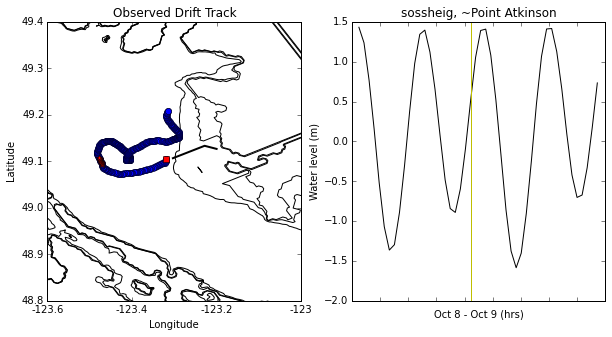

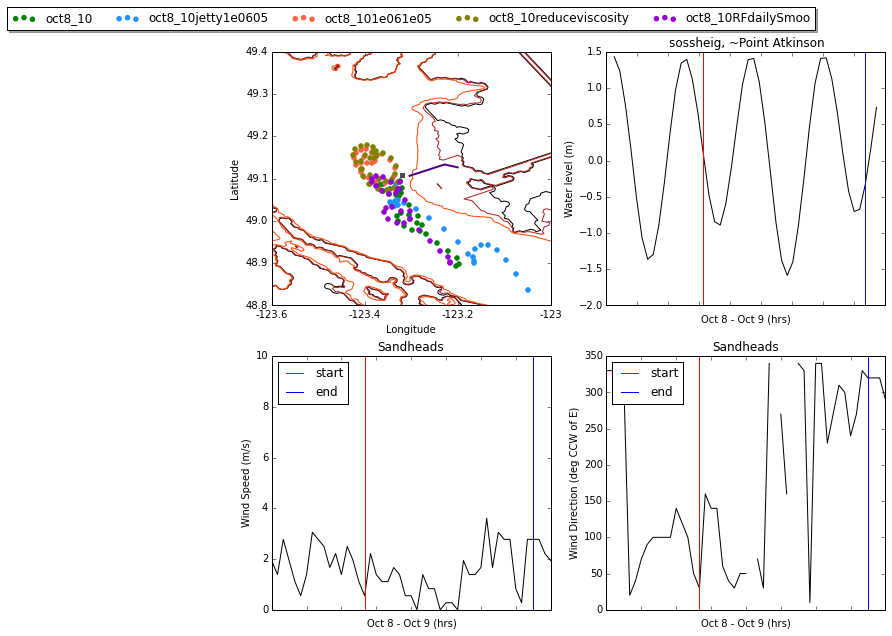

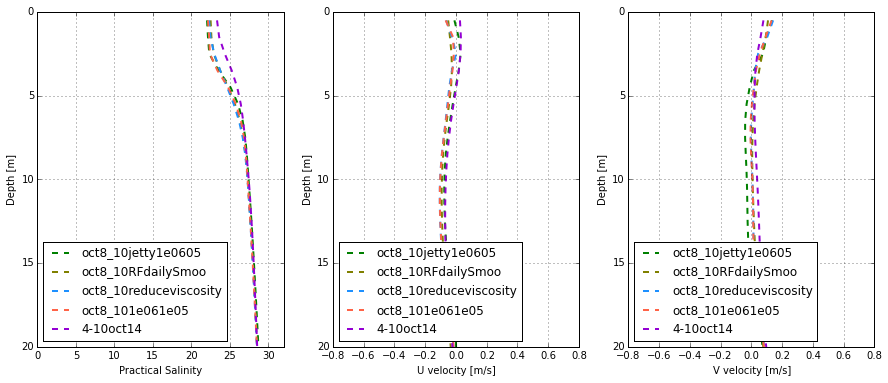

In [12]:
## python grid point (429, 290) for 29 hours,released at 16:00
buoy = 2
name, tracks=drifter.organize_info(buoy,ubc)
traj,jjj,iii,hour = drifter.plot_buoy_random(tracks, dt.datetime(2014,10,8), 8,22,i=-1, fancy=False)
lon_dri, lat_dri = drifter.after_1hr_buoy_location(tracks, dt.datetime(2014,10,8), -1)
## find dist between drifter and particle after 1hr
dist1 = dist_buoy_particle(lon_dri,lat_dri,lon112,lat112,0)
# for particle
fig=plotoct_mewold(lon112,lat112,0,'7-Oct-2014','11-Oct-2014',8,10,8,16,0,29)
# for vertical profiles
fig = plot_salinity_uv(jjj,iii, hour,0, 20)

Released 2014-10-08 17:30:08.000004 at 49.1064116667 , -123.320053333 for 28.249999998055557 hours
Random lat & lon in NEMO coords:

/home/jieliu/anaconda3/lib/python3.4/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/jieliu/anaconda3/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


 431 296


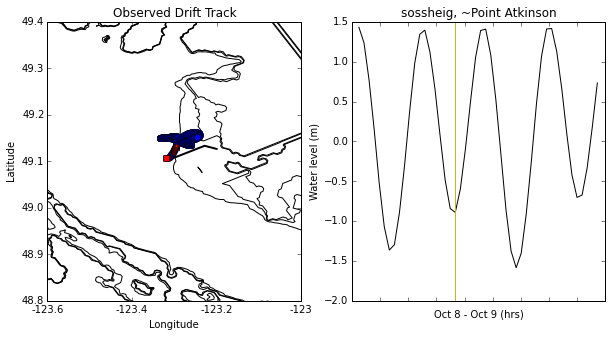

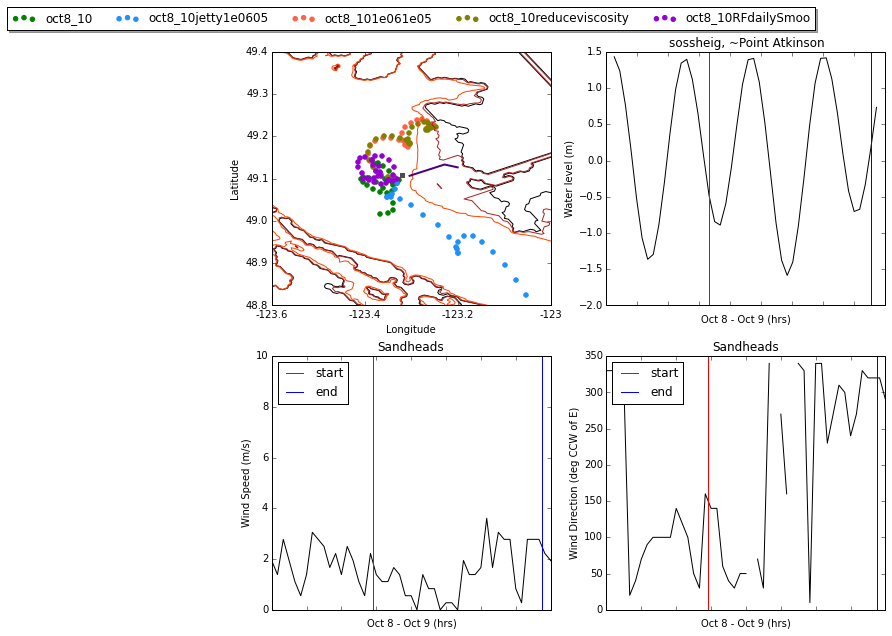

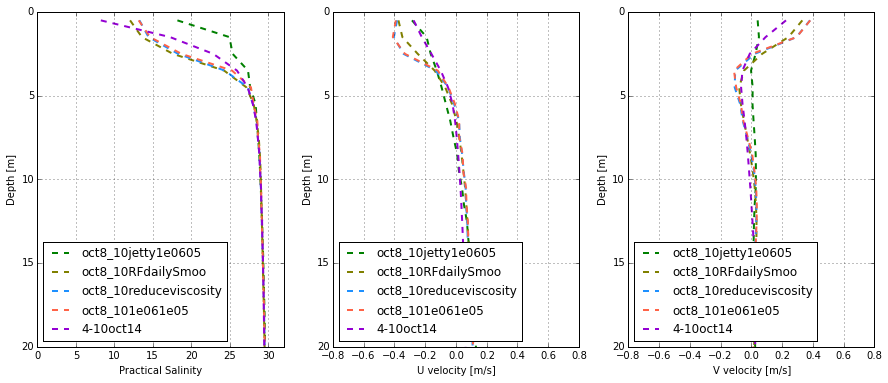

In [13]:
## python grid point (429,290) at 17:30 for 29hrs
buoy = 3
name, tracks=drifter.organize_info(buoy,ubc)
traj,jjj,iii,hour = drifter.plot_buoy_random(tracks, dt.datetime(2014,10,8), 8,19,i=-1, fancy=False)
lon_dri, lat_dri = drifter.after_1hr_buoy_location(tracks, dt.datetime(2014,10,8), -1)
dist2 = dist_buoy_particle(lon_dri,lat_dri,lon112,lat112,1)
fig=plotoct_mewold(lon112,lat112,1,'7-Oct-2014','11-Oct-2014',8,10,8,17,30,29)
fig = plot_salinity_uv(jjj,iii, hour,0, 20)

In [14]:
drop = 'drop1/3'
lon13 = {}; lat13={}
for run in runs:
    path = os.path.join(base,run, drop,file_pattern)
    f = nc.Dataset(path,'r');
    lon13[run] = f.variables['traj_lon']
    lat13[run] = f.variables['traj_lat']

Released 2014-10-08 19:20:06.999998 at 49.1071733333 , -123.319563333 for 6.666666666111111 hours
Random lat & lon in NEMO coords:

/home/jieliu/anaconda3/lib/python3.4/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/jieliu/anaconda3/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


 429 291


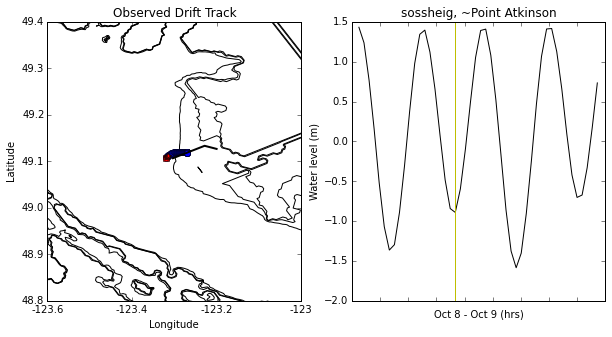

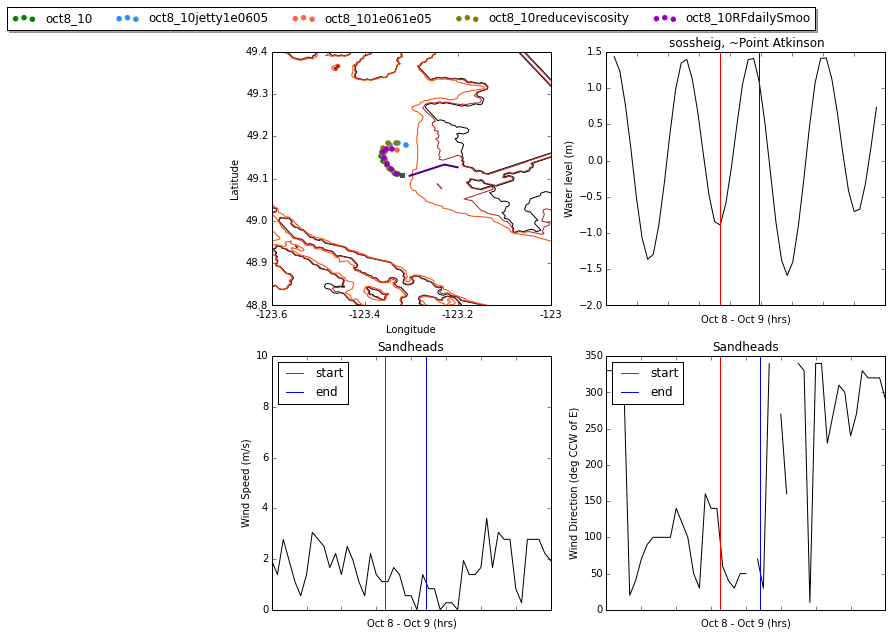

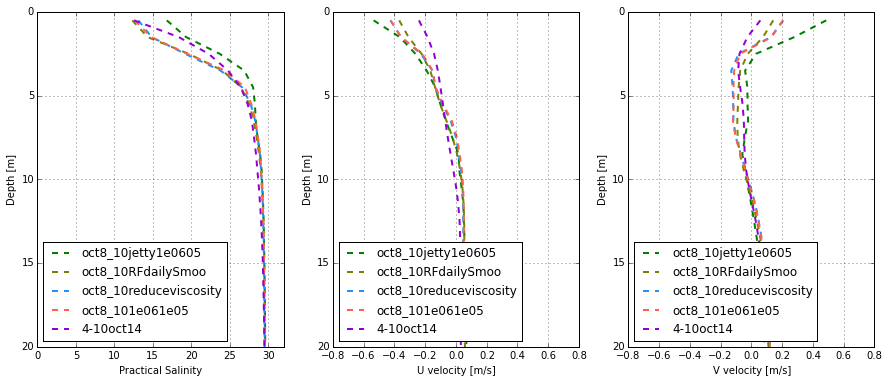

In [15]:
## python grid point (429,290) at 19:30 for 7hrs
buoy = 9
name, tracks=drifter.organize_info(buoy,ubc)
traj,jjj,iii,hour = drifter.plot_buoy_random(tracks, dt.datetime(2014,10,8), 8,19,i=-1, fancy=False)
lon_dri, lat_dri = drifter.after_1hr_buoy_location(tracks, dt.datetime(2014,10,8), -1)
dist3 = dist_buoy_particle(lon_dri,lat_dri,lon13,lat13,0)
fig=plotoct_mewold(lon13,lat13,0,'7-Oct-2014','11-Oct-2014',8,10,8,19,30,7)
fig = plot_salinity_uv(jjj,iii, hour,0, 20)

* Oct8 drop2

In [16]:
drop = 'drop2/12'
lon212 = {}; lat212={}
for run in runs:
    path = os.path.join(base,run, drop,file_pattern)
    f = nc.Dataset(path,'r');
    lon212[run] = f.variables['traj_lon']
    lat212[run] = f.variables['traj_lat']

Released 2014-10-08 16:05:07.999996 at 49.0956433333 , -123.320643333 for 26.499722222777777 hours
Random lat & lon in NEMO coords:

/home/jieliu/anaconda3/lib/python3.4/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/jieliu/anaconda3/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


 421 277


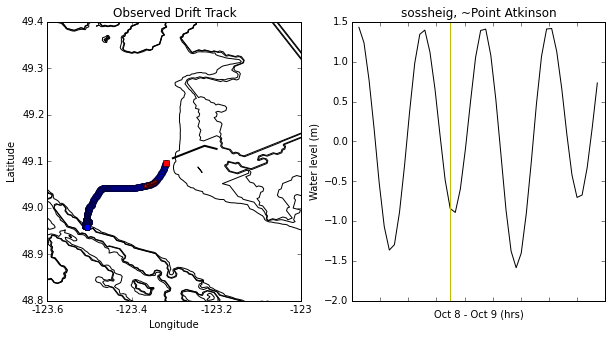

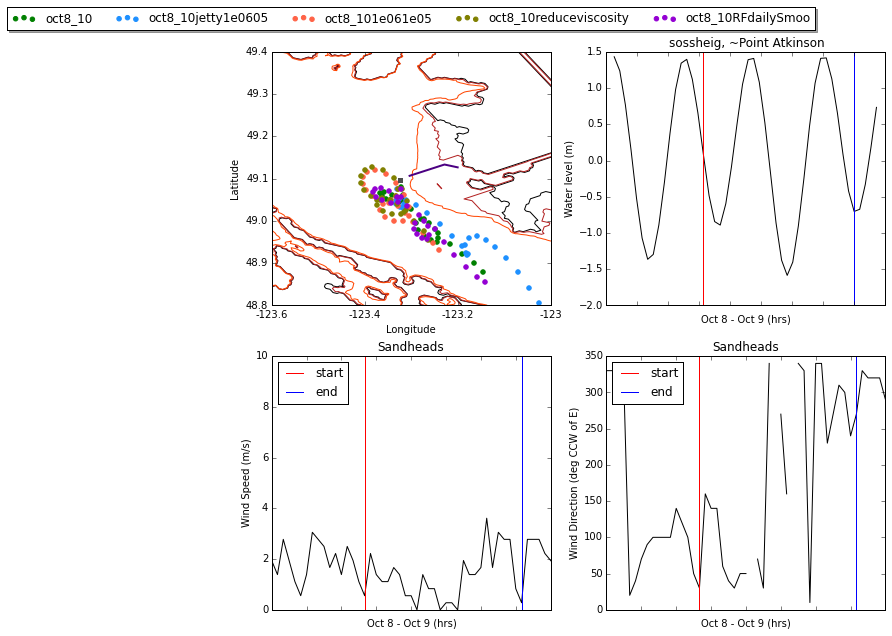

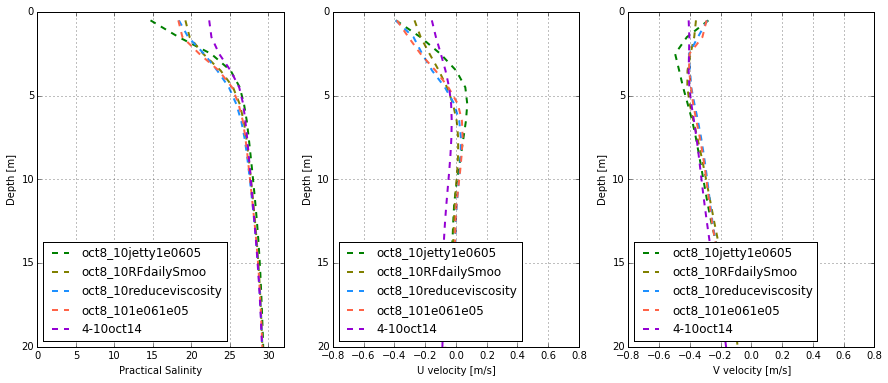

In [17]:
## python grid point (427,288) at 16:00 for 27hrs
buoy = 1
name, tracks=drifter.organize_info(buoy,ubc)
traj,jjj,iii,hour= drifter.plot_buoy_random(tracks, dt.datetime(2014,10,8), 8,18,i=-1, fancy=False)
lon_dri, lat_dri = drifter.after_1hr_buoy_location(tracks, dt.datetime(2014,10,8), -1)
dist4 = dist_buoy_particle(lon_dri,lat_dri,lon212,lat212,0)
fig = plotoct_mewold(lon212,lat212,0,'7-Oct-2014','11-Oct-2014',8,10,8,16,0,27)
fig = plot_salinity_uv(jjj,iii,hour,0, 20)

Released 2014-10-08 17:30:06.999999 at 49.0965066667 , -123.324513333 for 26.166944445 hours
Random lat & lon in NEMO coords:

/home/jieliu/anaconda3/lib/python3.4/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/jieliu/anaconda3/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


 429 277


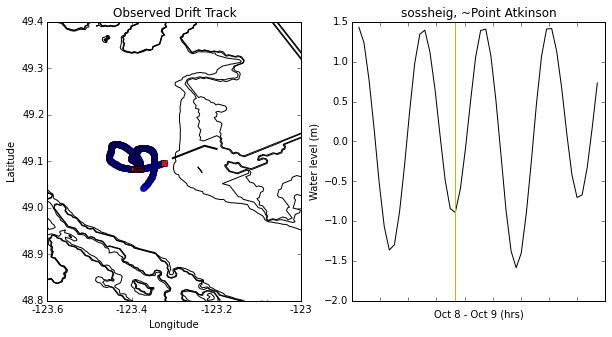

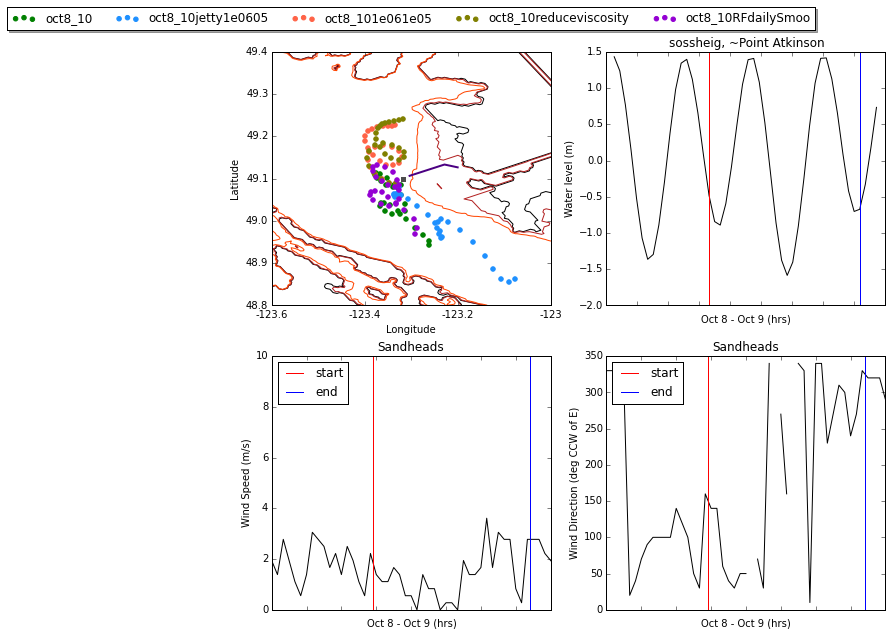

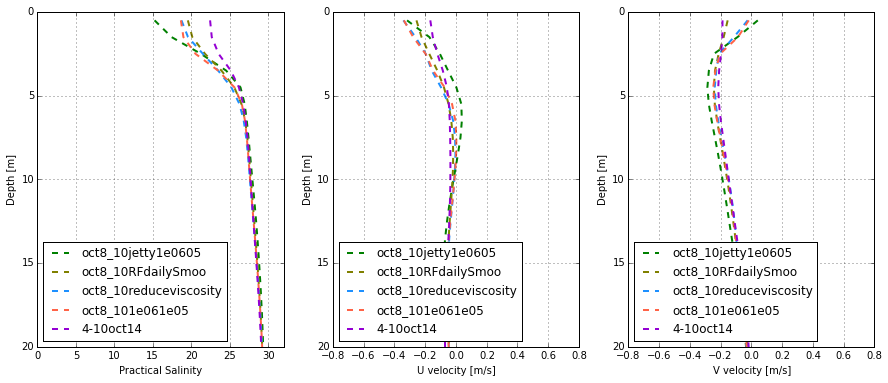

In [18]:
## python grid point (427,289) at 17:30 for 27hrs
buoy = 4
name, tracks=drifter.organize_info(buoy,ubc)
traj,jjj,iii,hour = drifter.plot_buoy_random(tracks, dt.datetime(2014,10,8), 8,19,i=-1, fancy=False)
lon_dri, lat_dri = drifter.after_1hr_buoy_location(tracks, dt.datetime(2014,10,8), -1)
dist5 = dist_buoy_particle(lon_dri,lat_dri,lon212,lat212,1)
fig = plotoct_mewold(lon212,lat212,1,'7-Oct-2014','11-Oct-2014',8,10,8,17,30,27)
fig = plot_salinity_uv(jjj,iii, hour,0, 20)

In [19]:
drop = 'drop2/3'
lon23 = {}; lat23={}
for run in runs:
    path = os.path.join(base,run, drop,file_pattern)
    f = nc.Dataset(path,'r');
    lon23[run] = f.variables['traj_lon']
    lat23[run] = f.variables['traj_lat']

Released 2014-10-08 19:20:08.999997 at 49.0943266667 , -123.330828333 for 24.91638888888889 hours
Random lat & lon in NEMO coords:

/home/jieliu/anaconda3/lib/python3.4/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/jieliu/anaconda3/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


 429 279


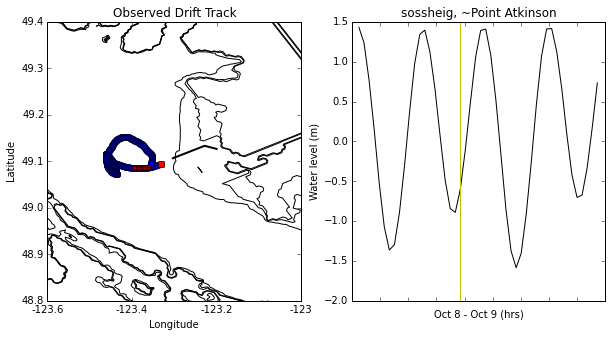

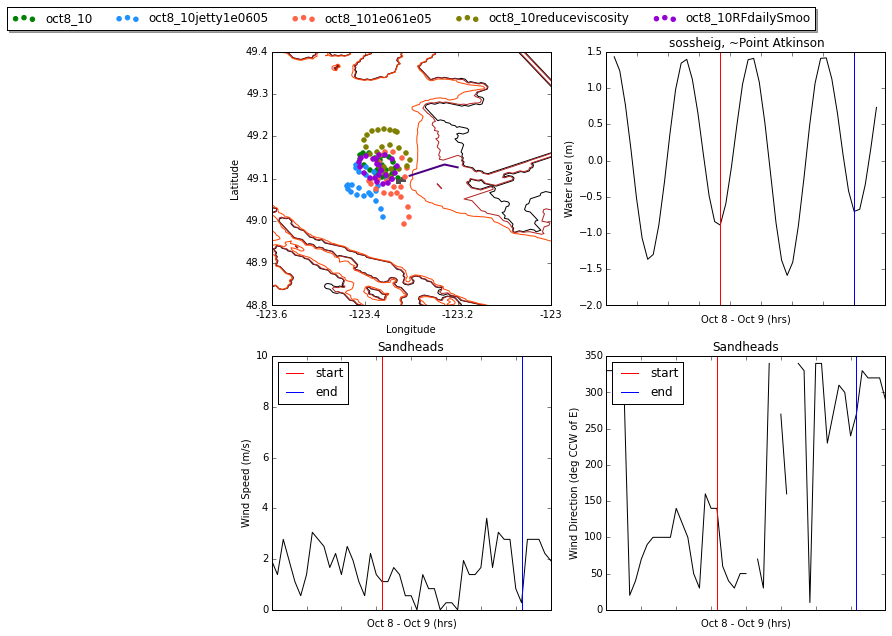

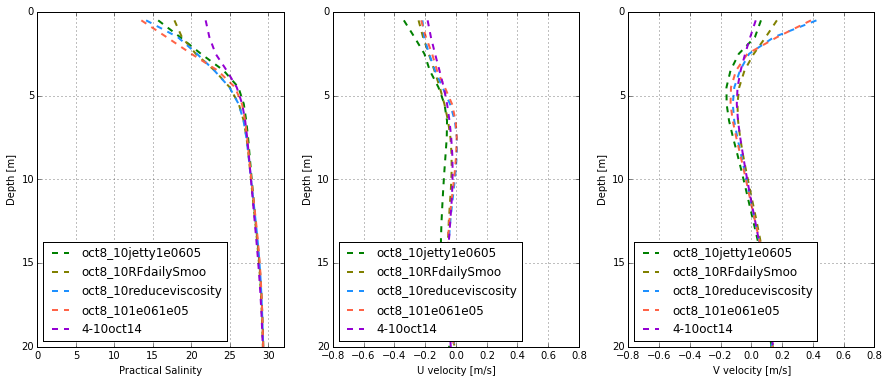

In [20]:
## python grid point (427,287) at 19:00 for 25hrs
buoy = 7
name, tracks=drifter.organize_info(buoy,ubc)
traj,jjj,iii,hour = drifter.plot_buoy_random(tracks, dt.datetime(2014,10,8), 8,20,i=-1, fancy=False)
lon_dri, lat_dri = drifter.after_1hr_buoy_location(tracks, dt.datetime(2014,10,8), -1)
dist6 = dist_buoy_particle(lon_dri,lat_dri,lon23,lat23,0)
fig = plotoct_mewold(lon23,lat23,0,'7-Oct-2014','11-Oct-2014',8,10,8,19,0,24)
fig = plot_salinity_uv(jjj,iii, hour,0, 20)

* Oct drop3

In [21]:
drop = 'drop3/1'
lon31 = {}; lat31={}
for run in runs:
    path = os.path.join(base,run, drop,file_pattern)
    f = nc.Dataset(path,'r');
    lon31[run] = f.variables['traj_lon']
    lat31[run] = f.variables['traj_lat']

Released 2014-10-08 16:00:06.999999 at 49.0862766667 , -123.320955 for 26.500277778055555 hours
Random lat & lon in NEMO coords:

/home/jieliu/anaconda3/lib/python3.4/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/jieliu/anaconda3/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


 422 268


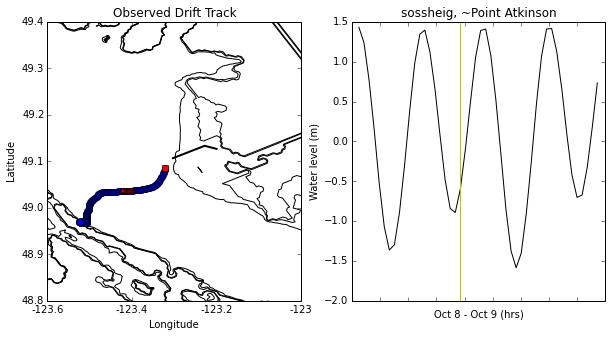

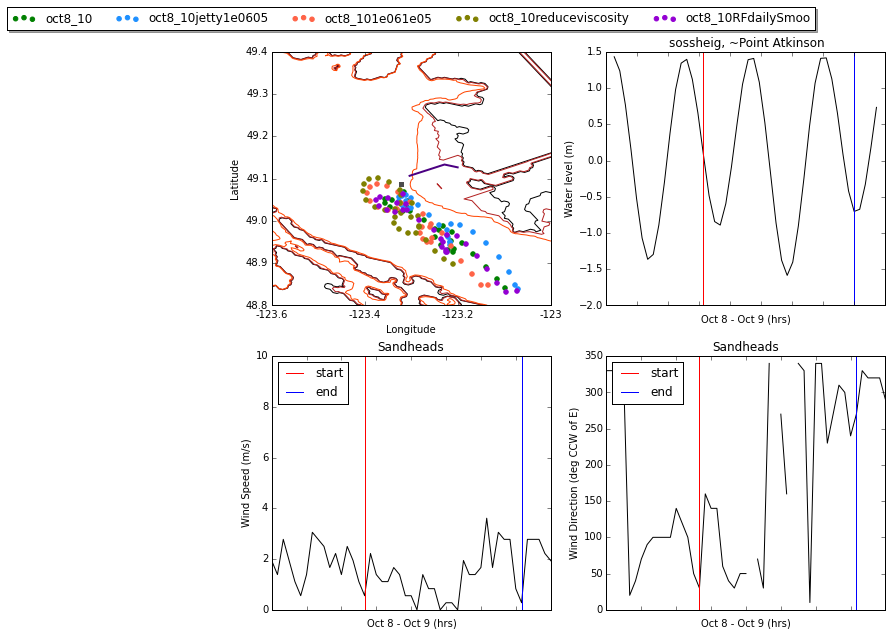

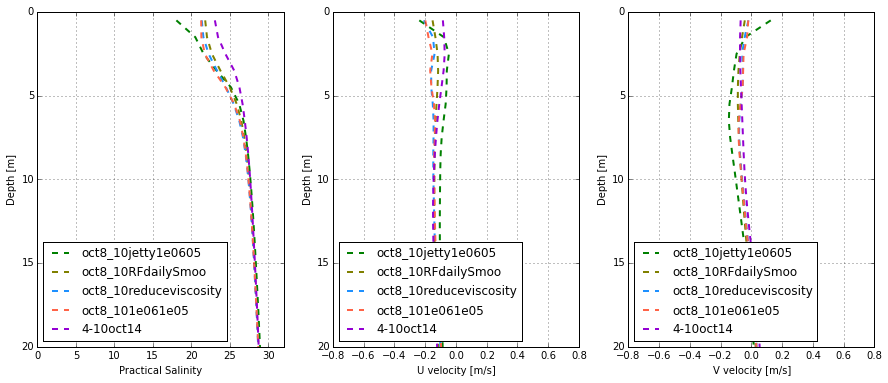

In [22]:
## python grid point (425,287) at 16:00 for 27hrs
buoy = 0
name, tracks=drifter.organize_info(buoy,ubc)
traj,jjj,iii,hour = drifter.plot_buoy_random(tracks, dt.datetime(2014,10,8), 8,20,i=-1, fancy=False)
lon_dri, lat_dri = drifter.after_1hr_buoy_location(tracks, dt.datetime(2014,10,8), -1)
dist7 = dist_buoy_particle(lon_dri,lat_dri,lon31,lat31,0)
fig = plotoct_mewold(lon31,lat31,0,'7-Oct-2014','11-Oct-2014',8,10,8,16,0,27)
fig = plot_salinity_uv(jjj,iii,hour,0, 20)

In [23]:
drop = 'drop3/23'
lon323 = {}; lat323={}
for run in runs:
    path = os.path.join(base,run, drop,file_pattern)
    f = nc.Dataset(path,'r');
    lon323[run] = f.variables['traj_lon']
    lat323[run] = f.variables['traj_lat']

Released 2014-10-08 17:35:07.000001 at 49.08599 , -123.323693333 for 23.83333333222222 hours
Random lat & lon in NEMO coords:

/home/jieliu/anaconda3/lib/python3.4/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/jieliu/anaconda3/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


 426 263


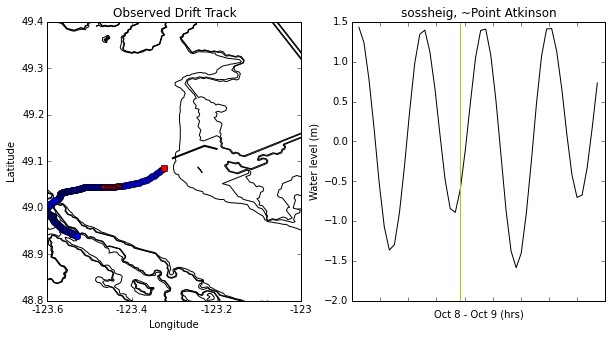

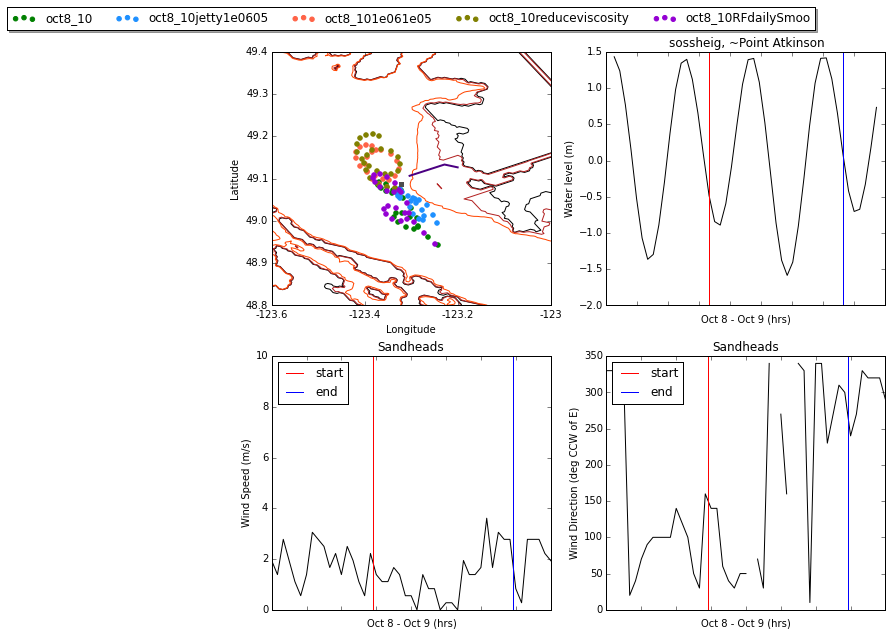

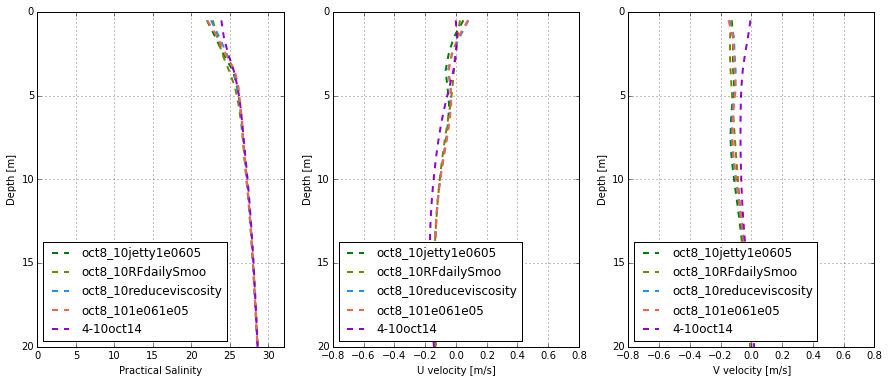

In [24]:
## python grid point (425,287) at 17:30 for 24hrs
buoy = 5
name, tracks=drifter.organize_info(buoy,ubc)
traj,jjj,iii,hour = drifter.plot_buoy_random(tracks, dt.datetime(2014,10,8), 8,20,i=-1, fancy=False)
lon_dri, lat_dri = drifter.after_1hr_buoy_location(tracks, dt.datetime(2014,10,8), -1)
dist8 = dist_buoy_particle(lon_dri,lat_dri,lon323,lat323,0)
fig = plotoct_mewold(lon323,lat323,0,'7-Oct-2014','11-Oct-2014',8,10,8,17,30,24)
fig = plot_salinity_uv(jjj,iii,hour,0, 20)

Released 2014-10-08 19:10:07.999998 at 49.0856266667 , -123.325655 for 23.08361111111111 hours
Random lat & lon in NEMO coords:

/home/jieliu/anaconda3/lib/python3.4/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/jieliu/anaconda3/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


 431 263


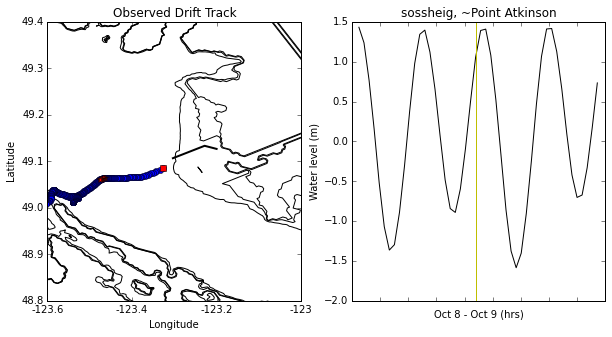

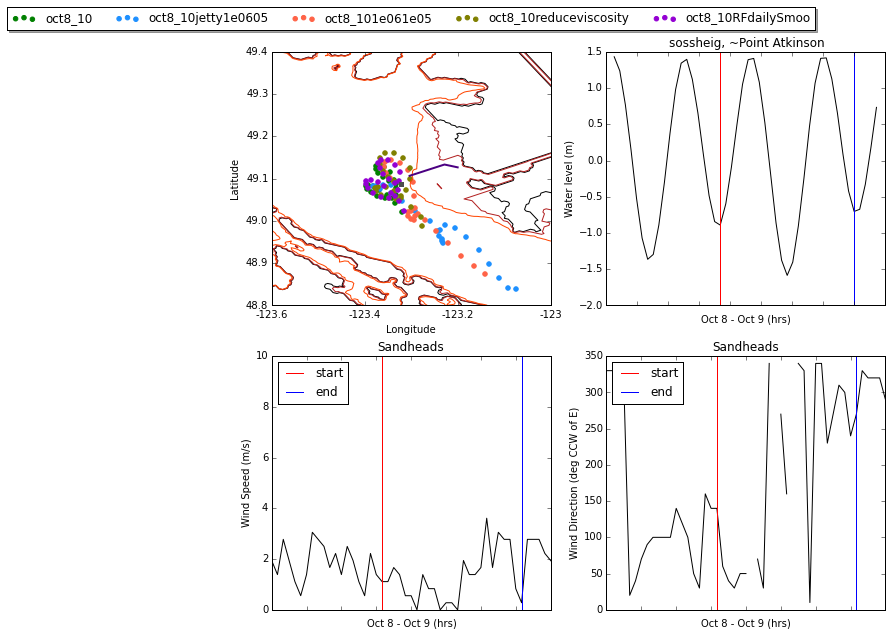

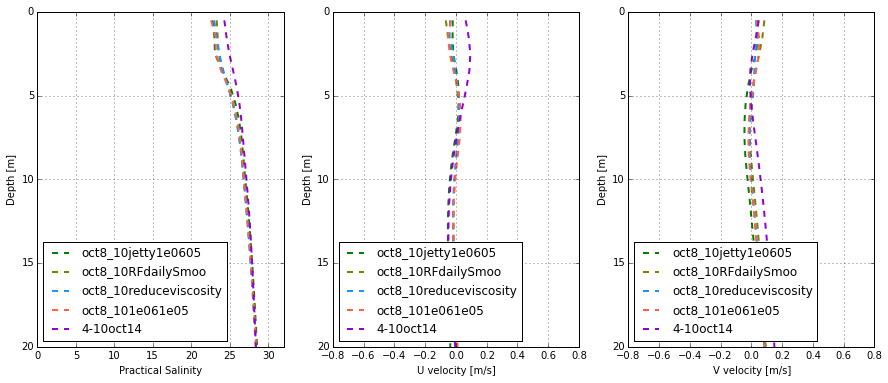

In [25]:
## python grid point (425,287) at 19:00 for 24hrs
buoy = 6
name, tracks=drifter.organize_info(buoy,ubc)
traj,jjj,iii,hour = drifter.plot_buoy_random(tracks, dt.datetime(2014,10,8), 8,23,i=-1, fancy=False)
lon_dri, lat_dri = drifter.after_1hr_buoy_location(tracks, dt.datetime(2014,10,8), -1)
dist9 = dist_buoy_particle(lon_dri,lat_dri,lon323,lat323,1)
fig = plotoct_mewold(lon323,lat323,1,'7-Oct-2014','11-Oct-2014',8,10,8,19,0,24)
fig = plot_salinity_uv(jjj,iii, hour,0, 20)

* Initial conditions did change surface currents compared with using june file as restart TSUV. Hard to tell if jetty is doing a good job in improving surface currents accuracy.
* Interesting to see with all reduced visco and diff, the particles could go further north and then turns back to the south only due to start from different initial conditions.
* Still, our cross-strait currents are not strong enough to push more freshwater offshore, but end up with more winding near the coast. Need to look at tides:
*  1) Barotropic tides: looks good at Steveston, Deas Island, too high water at New West and Mission.
*  2) Baroclinic tides: Nancy's simulation is on the way as well as M2, K1 tidal phase analysis. 

# Stastical analysis

In [26]:
## dists
dists = [dist1, dist2, dist3,dist4, dist5,\
            dist6, dist7,dist8,dist9]
oct8_10RFdailySmoo = []; oct8_10reduceviscosity=[];
oct8_101e061e05 = []; oct8_10jetty1e0605 = []; oct8_10 = []
for dist in dists:
    oct8_10RFdailySmoo.append(dist['oct8_10RFdailySmoo'])
    oct8_10reduceviscosity.append(dist['oct8_10reduceviscosity'])
    oct8_101e061e05.append(dist['oct8_101e061e05'])
    oct8_10jetty1e0605.append(dist['oct8_10jetty1e0605'])
    oct8_10.append(dist['oct8_10'])

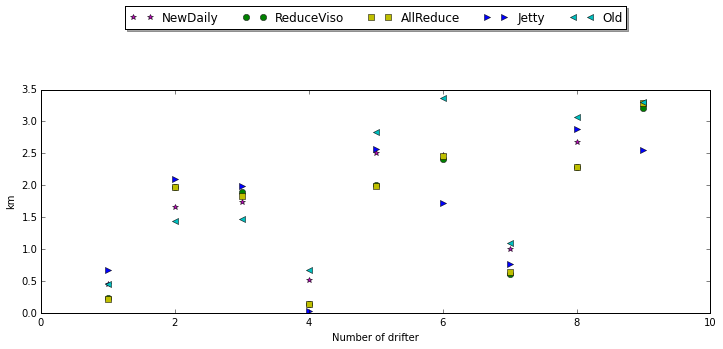

In [27]:
fig,ax1= plt.subplots(1,1,figsize=(12,4))
x = np.arange(9)
x+=1
NewDaily, = ax1.plot(x,oct8_10RFdailySmoo,'m*',label = 'NewDaily')
ReduceViso, = ax1.plot(x,oct8_10reduceviscosity,'go',label = 'ReduceViso')
AllReduce, = ax1.plot(x,oct8_101e061e05,'ys',label = 'AllReduce')
Jetty, = ax1.plot(x,oct8_10jetty1e0605,'b>', label = 'Jetty')
Old, =ax1.plot(x,oct8_10,'c<',label = 'Old')
ax1.set_xlabel('Number of drifter')
ax1.set_ylabel('km')
ax1.set_xlim([0,10])
ax1.legend(loc='upper center', bbox_to_anchor=(0.5, 1.4),
          ncol=5, fancybox=False, shadow=True)